In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2
from creation_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
df_P = pd.io.parsers.read_csv(filepath_or_buffer = 'data/F8_filt_10mino3.csv',index_col = 0)
print df_P[:5]

                     O3_ppb      UnixTime  e2v03    Temp      Rh  Wind  \
Date                                                                     
2014-07-11 07:40:00      41  1.405064e+09  43.84  25.400  45.376     0   
2014-07-11 07:41:00      42  1.405064e+09  46.36  25.400  45.300     0   
2014-07-11 07:42:00      40  1.405065e+09  47.92  25.388  45.396     0   
2014-07-11 07:43:00      35  1.405065e+09  46.32  25.332  45.496     0   
2014-07-11 07:44:00      33  1.405065e+09  44.20  25.296  45.616     0   

                     days from start  ref_o3_smooth  
Date                                                 
2014-07-11 07:40:00                0      42.440588  
2014-07-11 07:41:00                0      42.376680  
2014-07-11 07:42:00                0      42.190182  
2014-07-11 07:43:00                0      41.895266  
2014-07-11 07:44:00                0      41.513109  


In [155]:
df_P.drop(df_P.columns[[5]], axis=1, inplace=True)
print df_P[:5]

                     O3_ppb      UnixTime  e2v03    Temp      Rh  \
Date                                                               
2014-07-11 07:40:00      41  1.405064e+09  43.84  25.400  45.376   
2014-07-11 07:41:00      42  1.405064e+09  46.36  25.400  45.300   
2014-07-11 07:42:00      40  1.405065e+09  47.92  25.388  45.396   
2014-07-11 07:43:00      35  1.405065e+09  46.32  25.332  45.496   
2014-07-11 07:44:00      33  1.405065e+09  44.20  25.296  45.616   

                     days from start  ref_o3_smooth  
Date                                                 
2014-07-11 07:40:00                0      42.440588  
2014-07-11 07:41:00                0      42.376680  
2014-07-11 07:42:00                0      42.190182  
2014-07-11 07:43:00                0      41.895266  
2014-07-11 07:44:00                0      41.513109  


In [156]:
#ozone terms
df_P['O3_sqrt'] = np.sqrt(df_P['e2v03'].astype(float))
df_P['O3_sq'] = df_P['e2v03']**2
df_P['O3_cu'] = df_P['e2v03']**3
df_P['ln_O3'] = np.log(df_P['e2v03'])

#temp terms
df_P['temp_sqrt'] = np.sqrt(df_P['Temp'].astype(float))
df_P['temp_sq'] = df_P['Temp']**2
df_P['temp_cu'] = df_P['Temp']**3
df_P['ln_temp'] =np.log(df_P['Temp'])

#rh terms
df_P['rh_sqrt'] = np.sqrt(df_P['Rh'].astype(float))
df_P['rh_sq'] = df_P['Rh']**2
df_P['rh_cu'] = df_P['Rh']**3
df_P['ln_rh'] = np.log(df_P['Rh'])

#ozone/temp interactions
df_P['03_mult_temp'] = df_P['e2v03']*df_P['Temp']
df_P['03_sq_mult_temp_sq'] = ((df_P['e2v03'])**2)*df_P['Temp']**2
df_P['ln_03_mult_ln_temp'] = np.log(df_P['Temp'])*np.log(df_P['e2v03'])

#ozone/rh interactions
df_P['03_mult_rh'] = df_P['e2v03']*df_P['Rh']
df_P['03_sq_mult_rh_sq'] = (df_P['e2v03']**2)*df_P['Rh']**2
df_P['ln_03_mult_ln_rh'] = np.log(df_P['Rh'])*np.log(df_P['e2v03'])

#temp/rh interactions
df_P['temp_mult_rh'] = df_P['Temp']*df_P['Rh']
df_P['temp_sq_mult_rh_sq'] = (df_P['Temp']**2)*df_P['Rh']**2
df_P['ln_temp_mult_ln_rh'] = np.log(df_P['Temp'])*np.log(df_P['Rh'])

#ozone/rh/temp interactions
df_P['03_mult_rh_&_temp'] = df_P['e2v03']*df_P['Rh']*df_P['Temp']
df_P['03_sq_mult_rh_sq_&_temp_sq'] = (df_P['e2v03']**2)*(df_P['Rh']**2)*df_P['Temp']**2
df_P['ln_03_mult_ln_rh_&_ln_temp'] = np.log(df_P['Temp'])*np.log(df_P['Rh'])*np.log(df_P['e2v03'])

feature_list = ['e2v03', 'ln_O3', 'Temp', 'ln_temp', 'Rh', 'ln_rh']

for i in range(0,len(feature_list)):
    make_func_caller_find_lag_integral(df_P, 15, 90, 15, feature_list[i])
    make_func_caller_find_lead_integral(df_P, 15, 90, 15, feature_list[i])
    make_func_caller_find_lag_slope(df_P, 15, 90, 15, feature_list[i])
    make_func_caller_find_lead_slope(df_P, 15, 90, 15, feature_list[i])
    make_func_caller_find_lag_integral(df_P, 5, 5, 15, feature_list[i])
    make_func_caller_find_lead_integral(df_P, 5, 5, 15, feature_list[i])
    make_func_caller_find_lag_slope(df_P, 5, 5, 15, feature_list[i])
    make_func_caller_find_lead_slope(df_P, 5, 5, 15, feature_list[i])

features = list(df_P.columns)
print features

['O3_ppb', 'UnixTime', 'e2v03', 'Temp', 'Rh', 'days from start', 'ref_o3_smooth', 'O3_sqrt', 'O3_sq', 'O3_cu', 'ln_O3', 'temp_sqrt', 'temp_sq', 'temp_cu', 'ln_temp', 'rh_sqrt', 'rh_sq', 'rh_cu', 'ln_rh', '03_mult_temp', '03_sq_mult_temp_sq', 'ln_03_mult_ln_temp', '03_mult_rh', '03_sq_mult_rh_sq', 'ln_03_mult_ln_rh', 'temp_mult_rh', 'temp_sq_mult_rh_sq', 'ln_temp_mult_ln_rh', '03_mult_rh_&_temp', '03_sq_mult_rh_sq_&_temp_sq', 'ln_03_mult_ln_rh_&_ln_temp', 'e2v03_int_lag_15', 'e2v03_int_lag_30', 'e2v03_int_lag_45', 'e2v03_int_lag_60', 'e2v03_int_lag_75', 'e2v03_int_lag_90', 'e2v03_int_lead_15', 'e2v03_int_lead_30', 'e2v03_int_lead_45', 'e2v03_int_lead_60', 'e2v03_int_lead_75', 'e2v03_int_lead_90', 'diff', 'e2v03_slope_lag_15', 'e2v03_slope_lag_30', 'e2v03_slope_lag_45', 'e2v03_slope_lag_60', 'e2v03_slope_lag_75', 'e2v03_slope_lag_90', 'e2v03_slope_lead_15', 'e2v03_slope_lead_30', 'e2v03_slope_lead_45', 'e2v03_slope_lead_60', 'e2v03_slope_lead_75', 'e2v03_slope_lead_90', 'e2v03_int_lag_5'

In [157]:
#Delete the first and last 90 rows of the dataframe to remove all NaNs.
df_P = df_P.ix[90:len(df_P['e2v03'])-90]

In [158]:
#ozone/temp
df_P['o3_temp_int_lag_30'] = df_P['e2v03_int_lag_30'] * df_P['Temp_int_lag_30'] 
df_P['o3_temp_slope_lag_30'] = df_P['e2v03_slope_lag_30'] * df_P['Temp_slope_lag_30']
df_P['o3_temp_int_lag_60'] = df_P['e2v03_int_lag_60'] * df_P['Temp_int_lag_60'] 
df_P['o3_temp_slope_lag_60'] = df_P['e2v03_slope_lag_60'] * df_P['Temp_slope_lag_60'] 
df_P['o3_temp_int_lag_90'] = df_P['e2v03_int_lag_90'] * df_P['Temp_int_lag_90'] 
df_P['o3_temp_slope_lag_90'] = df_P['e2v03_slope_lag_90'] * df_P['Temp_slope_lag_90']
df_P['o3_temp_int_lag_5'] = df_P['e2v03_int_lag_5'] * df_P['Temp_int_lag_5'] 
df_P['o3_temp_slope_lag_5'] = df_P['e2v03_slope_lag_5'] * df_P['Temp_slope_lag_5']

df_P['ln_o3_temp_int_lag_30'] = df_P['ln_O3_int_lag_30'] * df_P['ln_temp_int_lag_30'] 
df_P['ln_o3_temp_slope_lag_30'] = df_P['ln_O3_slope_lag_30'] * df_P['ln_temp_slope_lag_30']
df_P['ln_o3_temp_int_lag_60'] = df_P['ln_O3_int_lag_60'] * df_P['ln_temp_int_lag_60'] 
df_P['ln_o3_temp_slope_lag_60'] = df_P['ln_O3_slope_lag_60'] * df_P['ln_temp_slope_lag_60'] 
df_P['ln_o3_temp_int_lag_90'] = df_P['ln_O3_int_lag_90'] * df_P['ln_temp_int_lag_90'] 
df_P['ln_o3_temp_slope_lag_90'] = df_P['ln_O3_slope_lag_90'] * df_P['ln_temp_slope_lag_90']
df_P['ln_o3_temp_int_lag_5'] = df_P['ln_O3_int_lag_5'] * df_P['ln_temp_int_lag_5'] 
df_P['ln_o3_temp_slope_lag_5'] = df_P['ln_O3_slope_lag_5'] * df_P['ln_temp_slope_lag_5']

df_P['o3_temp_int_lead_30'] = df_P['e2v03_int_lead_30'] * df_P['Temp_int_lead_30'] 
df_P['o3_temp_slope_lead_30'] = df_P['e2v03_slope_lead_30'] * df_P['Temp_slope_lead_30'] 
df_P['o3_temp_int_lead_60'] = df_P['e2v03_int_lead_60'] * df_P['Temp_int_lead_60'] 
df_P['o3_temp_slope_lead_60'] = df_P['e2v03_slope_lead_60'] * df_P['Temp_slope_lead_60'] 
df_P['o3_temp_int_lead_90'] = df_P['e2v03_int_lead_90'] * df_P['Temp_int_lead_90'] 
df_P['o3_temp_slope_lead_90'] = df_P['e2v03_slope_lead_90'] * df_P['Temp_slope_lead_90']
df_P['o3_temp_int_lead_5'] = df_P['e2v03_int_lead_5'] * df_P['Temp_int_lead_5'] 
df_P['o3_temp_slope_lead_5'] = df_P['e2v03_slope_lead_5'] * df_P['Temp_slope_lead_5']

df_P['ln_o3_temp_int_lead_30'] = df_P['ln_O3_int_lead_30'] * df_P['ln_temp_int_lead_30'] 
df_P['ln_o3_temp_slope_lead_30'] = df_P['ln_O3_slope_lead_30'] * df_P['ln_temp_slope_lead_30'] 
df_P['ln_o3_temp_int_lead_60'] = df_P['ln_O3_int_lead_60'] * df_P['ln_temp_int_lead_60'] 
df_P['ln_o3_temp_slope_lead_60'] = df_P['ln_O3_slope_lead_60'] * df_P['ln_temp_slope_lead_60'] 
df_P['ln_o3_temp_int_lead_90'] = df_P['ln_O3_int_lead_90'] * df_P['ln_temp_int_lead_90'] 
df_P['ln_o3_temp_slope_lead_90'] = df_P['ln_O3_slope_lead_90'] * df_P['ln_temp_slope_lead_90']
df_P['ln_o3_temp_int_lead_5'] = df_P['ln_O3_int_lead_5'] * df_P['ln_temp_int_lead_5'] 
df_P['ln_o3_temp_slope_lead_5'] = df_P['ln_O3_slope_lead_5'] * df_P['ln_temp_slope_lead_5']

#temp/rh
df_P['temp_rh_int_lag_30'] = df_P['Temp_int_lag_30'] * df_P['Rh_int_lag_30'] 
df_P['temp_rh_slope_lag_30'] = df_P['Temp_slope_lag_30'] * df_P['Rh_slope_lag_30'] 
df_P['temp_rh_int_lag_60'] = df_P['Temp_int_lag_60'] * df_P['Rh_int_lag_60'] 
df_P['temp_rh_slope_lag_60'] = df_P['Temp_slope_lag_60'] * df_P['Rh_slope_lag_60'] 
df_P['temp_rh_int_lag_90'] = df_P['Temp_int_lag_90'] * df_P['Rh_int_lag_90'] 
df_P['temp_rh_slope_lag_90'] = df_P['Temp_slope_lag_90'] * df_P['Rh_slope_lag_90'] 
df_P['temp_rh_int_lag_5'] = df_P['Temp_int_lag_5'] * df_P['Rh_int_lag_5'] 
df_P['temp_rh_slope_lag_5'] = df_P['Temp_slope_lag_5'] * df_P['Rh_slope_lag_5']

df_P['ln_temp_rh_int_lag_30'] = df_P['ln_temp_int_lag_30'] * df_P['ln_rh_int_lag_30'] 
df_P['ln_temp_rh_slope_lag_30'] = df_P['ln_temp_slope_lag_30'] * df_P['ln_rh_slope_lag_30'] 
df_P['ln_temp_rh_int_lag_60'] = df_P['ln_temp_int_lag_60'] * df_P['ln_rh_int_lag_60'] 
df_P['ln_temp_rh_slope_lag_60'] = df_P['ln_temp_slope_lag_60'] * df_P['ln_rh_slope_lag_60'] 
df_P['ln_temp_rh_int_lag_90'] = df_P['ln_temp_int_lag_90'] * df_P['ln_rh_int_lag_90'] 
df_P['ln_temp_rh_slope_lag_90'] = df_P['ln_temp_slope_lag_90'] * df_P['ln_rh_slope_lag_90'] 
df_P['ln_temp_rh_int_lag_5'] = df_P['ln_temp_int_lag_5'] * df_P['ln_rh_int_lag_5'] 
df_P['ln_temp_rh_slope_lag_5'] = df_P['ln_temp_slope_lag_5'] * df_P['ln_rh_slope_lag_5']

df_P['temp_rh_int_lead_30'] = df_P['Temp_int_lead_30'] * df_P['Rh_int_lead_30'] 
df_P['temp_rh_slope_lead_30'] = df_P['Temp_slope_lead_30'] * df_P['Rh_slope_lead_30'] 
df_P['temp_rh_int_lead_60'] = df_P['Temp_int_lead_60'] * df_P['Rh_int_lead_60'] 
df_P['temp_rh_slope_lead_60'] = df_P['Temp_slope_lead_60'] * df_P['Rh_slope_lead_60'] 
df_P['temp_rh_int_lead_90'] = df_P['Temp_int_lead_90'] * df_P['Rh_int_lead_90'] 
df_P['temp_rh_slope_lead_90'] = df_P['Temp_slope_lead_90'] * df_P['Rh_slope_lead_90']
df_P['temp_rh_int_lead_5'] = df_P['Temp_int_lead_5'] * df_P['Rh_int_lead_5'] 
df_P['temp_rh_slope_lead_5'] = df_P['Temp_slope_lead_5'] * df_P['Rh_slope_lead_5']

df_P['ln_temp_rh_int_lead_30'] = df_P['ln_temp_int_lead_30'] * df_P['ln_rh_int_lead_30'] 
df_P['ln_temp_rh_slope_lead_30'] = df_P['ln_temp_slope_lead_30'] * df_P['ln_rh_slope_lead_30'] 
df_P['ln_temp_rh_int_lead_60'] = df_P['ln_temp_int_lead_60'] * df_P['ln_rh_int_lead_60'] 
df_P['ln_temp_rh_slope_lead_60'] = df_P['ln_temp_slope_lead_60'] * df_P['ln_rh_slope_lead_60'] 
df_P['ln_temp_rh_int_lead_90'] = df_P['ln_temp_int_lead_90'] * df_P['ln_rh_int_lead_90'] 
df_P['ln_temp_rh_slope_lead_5'] = df_P['ln_temp_slope_lead_5'] * df_P['ln_rh_slope_lead_5']
df_P['ln_temp_rh_int_lead_5'] = df_P['ln_temp_slope_lead_5'] * df_P['ln_rh_slope_lead_5']

#ozone/rh
df_P['o3_rh_int_lag_30'] = df_P['e2v03_int_lag_30'] * df_P['Rh_int_lag_30'] 
df_P['o3_rh_slope_lag_30'] = df_P['e2v03_slope_lag_30'] * df_P['Rh_slope_lag_30'] 
df_P['o3_rh_int_lag_60'] = df_P['e2v03_int_lag_60'] * df_P['Rh_int_lag_60'] 
df_P['o3_rh_slope_lag_60'] = df_P['e2v03_slope_lag_60'] * df_P['Rh_slope_lag_60'] 
df_P['o3_rh_int_lag_90'] = df_P['e2v03_int_lag_90'] * df_P['Rh_int_lag_90'] 
df_P['o3_rh_slope_lag_90'] = df_P['e2v03_slope_lag_90'] * df_P['Rh_slope_lag_90'] 
df_P['o3_rh_int_lag_5'] = df_P['e2v03_int_lag_5'] * df_P['Rh_int_lag_5'] 
df_P['o3_rh_slope_lag_5'] = df_P['e2v03_slope_lag_5'] * df_P['Rh_slope_lag_5'] 

df_P['ln_o3_rh_int_lag_30'] = df_P['ln_O3_int_lag_30'] * df_P['ln_rh_int_lag_30'] 
df_P['ln_o3_rh_slope_lag_30'] = df_P['ln_O3_slope_lag_30'] * df_P['ln_rh_slope_lag_30'] 
df_P['ln_o3_rh_int_lag_60'] = df_P['ln_O3_int_lag_60'] * df_P['ln_rh_int_lag_60'] 
df_P['ln_o3_rh_slope_lag_60'] = df_P['ln_O3_slope_lag_60'] * df_P['ln_rh_slope_lag_60'] 
df_P['ln_o3_rh_int_lag_90'] = df_P['ln_O3_int_lag_90'] * df_P['ln_rh_int_lag_90'] 
df_P['ln_o3_rh_slope_lag_90'] = df_P['ln_O3_slope_lag_90'] * df_P['ln_rh_slope_lag_90'] 
df_P['ln_o3_rh_int_lag_5'] = df_P['ln_O3_int_lag_5'] * df_P['ln_rh_int_lag_5'] 
df_P['ln_o3_rh_slope_lag_5'] = df_P['ln_O3_slope_lag_5'] * df_P['ln_rh_slope_lag_5'] 

df_P['o3_rh_int_lead_30'] = df_P['e2v03_int_lead_30'] * df_P['Rh_int_lead_30'] 
df_P['o3_rh_slope_lead_30'] = df_P['e2v03_slope_lead_30'] * df_P['Rh_slope_lead_30'] 
df_P['o3_rh_int_lead_60'] = df_P['e2v03_int_lead_60'] * df_P['Rh_int_lead_60'] 
df_P['o3_rh_slope_lead_60'] = df_P['e2v03_slope_lead_60'] * df_P['Rh_slope_lead_60'] 
df_P['o3_rh_int_lead_90'] = df_P['e2v03_int_lead_90'] * df_P['Rh_int_lead_90'] 
df_P['o3_rh_slope_lead_90'] = df_P['e2v03_slope_lead_90'] * df_P['Rh_slope_lead_90']
df_P['o3_rh_int_lead_5'] = df_P['e2v03_int_lead_5'] * df_P['Rh_int_lead_5'] 
df_P['o3_rh_slope_lead_5'] = df_P['e2v03_slope_lead_5'] * df_P['Rh_slope_lead_5']

df_P['ln_o3_rh_int_lead_30'] = df_P['ln_O3_int_lead_30'] * df_P['ln_rh_int_lead_30'] 
df_P['ln_o3_rh_slope_lead_30'] = df_P['ln_O3_slope_lead_30'] * df_P['ln_rh_slope_lead_30'] 
df_P['ln_o3_rh_int_lead_60'] = df_P['ln_O3_int_lead_60'] * df_P['ln_rh_int_lead_60'] 
df_P['ln_o3_rh_slope_lead_60'] = df_P['ln_O3_slope_lead_60'] * df_P['ln_rh_slope_lead_60'] 
df_P['ln_o3_rh_int_lead_90'] = df_P['ln_O3_int_lead_90'] * df_P['ln_rh_int_lead_90'] 
df_P['ln_o3_rh_slope_lead_90'] = df_P['ln_O3_slope_lead_90'] * df_P['ln_rh_slope_lead_90']
df_P['ln_o3_rh_int_lead_5'] = df_P['ln_O3_int_lead_5'] * df_P['ln_rh_int_lead_5'] 
df_P['ln_o3_rh_slope_lead_5'] = df_P['ln_O3_slope_lead_5'] * df_P['ln_rh_slope_lead_5']

#ozone/temp/rh
df_P['o3_temp_rh_int_lag_30'] = df_P['Temp_int_lag_30'] * df_P['Rh_int_lag_30']*df_P['e2v03_int_lag_30'] 
df_P['o3_temp_rh_slope_lag_30'] = df_P['Temp_slope_lag_30'] * df_P['Rh_slope_lag_30'] * df_P['e2v03_slope_lag_30'] 
df_P['o3_temp_rh_int_lag_60'] = df_P['Temp_int_lag_60'] * df_P['Rh_int_lag_60']*df_P['e2v03_int_lag_60'] 
df_P['o3_temp_rh_slope_lag_60'] = df_P['Temp_slope_lag_60'] * df_P['Rh_slope_lag_60'] * df_P['e2v03_slope_lag_60'] 
df_P['o3_temp_rh_int_lag_90'] = df_P['Temp_int_lag_90'] * df_P['Rh_int_lag_90'] * df_P['e2v03_int_lag_90']
df_P['o3_temp_rh_slope_lag_90'] = df_P['Temp_slope_lag_90'] * df_P['Rh_slope_lag_90'] * df_P['e2v03_slope_lag_90'] 
df_P['o3_temp_rh_int_lag_5'] = df_P['Temp_int_lag_5'] * df_P['Rh_int_lag_5'] * df_P['e2v03_int_lag_5']
df_P['o3_temp_rh_slope_lag_5'] = df_P['Temp_slope_lag_5'] * df_P['Rh_slope_lag_5'] * df_P['e2v03_slope_lag_5'] 

df_P['ln_o3_temp_rh_int_lag_30'] = df_P['ln_temp_int_lag_30'] * df_P['ln_rh_int_lag_30']*df_P['ln_O3_int_lag_30'] 
df_P['ln_o3_temp_rh_slope_lag_30'] = df_P['ln_temp_slope_lag_30'] * df_P['ln_rh_slope_lag_30'] * df_P['ln_O3_slope_lag_30'] 
df_P['ln_o3_temp_rh_int_lag_60'] = df_P['ln_temp_int_lag_60'] * df_P['ln_rh_int_lag_60']*df_P['ln_O3_int_lag_60'] 
df_P['ln_o3_temp_rh_slope_lag_60'] = df_P['ln_temp_slope_lag_60'] * df_P['ln_rh_slope_lag_60'] * df_P['ln_O3_slope_lag_60'] 
df_P['ln_o3_temp_rh_int_lag_90'] = df_P['ln_temp_int_lag_90'] * df_P['ln_rh_int_lag_90'] * df_P['ln_O3_int_lag_90']
df_P['ln_o3_temp_rh_slope_lag_90'] = df_P['ln_temp_slope_lag_90'] * df_P['ln_rh_slope_lag_90'] * df_P['ln_O3_slope_lag_90'] 
df_P['ln_o3_temp_rh_int_lag_5'] = df_P['ln_temp_int_lag_5'] * df_P['ln_rh_int_lag_5'] * df_P['ln_O3_int_lag_5']
df_P['ln_o3_temp_rh_slope_lag_5'] = df_P['ln_temp_slope_lag_5'] * df_P['ln_rh_slope_lag_5'] * df_P['ln_O3_slope_lag_5'] 

df_P['o3_temp_rh_int_lead_30'] = df_P['Temp_int_lead_30'] * df_P['Rh_int_lead_30'] * df_P['e2v03_int_lead_30'] 
df_P['o3_temp_rh_slope_lead_30'] = df_P['Temp_slope_lead_30'] * df_P['Rh_slope_lead_30'] * df_P['e2v03_slope_lead_30']
df_P['o3_temp_rh_int_lead_60'] = df_P['Temp_int_lead_60'] * df_P['Rh_int_lead_60'] * df_P['e2v03_int_lead_60'] 
df_P['o3_temp_rh_slope_lead_60'] = df_P['Temp_slope_lead_60'] * df_P['Rh_slope_lead_60'] * df_P['e2v03_slope_lead_60'] 
df_P['o3_temp_rh_int_lead_90'] = df_P['Temp_int_lead_90'] * df_P['Rh_int_lead_90'] * df_P['e2v03_int_lead_90']
df_P['o3_temp_rh_slope_lead_90'] = df_P['Temp_slope_lead_90'] * df_P['Rh_slope_lead_90'] * df_P['e2v03_slope_lead_90']
df_P['o3_temp_rh_int_lead_5'] = df_P['Temp_int_lead_5'] * df_P['Rh_int_lead_5'] * df_P['e2v03_int_lead_5']
df_P['o3_temp_rh_slope_lead_5'] = df_P['Temp_slope_lead_5'] * df_P['Rh_slope_lead_5'] * df_P['e2v03_slope_lead_5']

df_P['ln_o3_temp_rh_int_lead_30'] = df_P['ln_temp_int_lead_30'] * df_P['ln_rh_int_lead_30'] * df_P['ln_O3_int_lead_30'] 
df_P['ln_o3_temp_rh_slope_lead_30'] = df_P['ln_temp_slope_lead_30'] * df_P['ln_rh_slope_lead_30'] * df_P['ln_O3_slope_lead_30']
df_P['ln_o3_temp_rh_int_lead_60'] = df_P['ln_temp_int_lead_60'] * df_P['ln_rh_int_lead_60'] * df_P['ln_O3_int_lead_60'] 
df_P['ln_o3_temp_rh_slope_lead_60'] = df_P['ln_temp_slope_lead_60'] * df_P['ln_rh_slope_lead_60'] * df_P['ln_O3_slope_lead_60']
df_P['ln_o3_temp_rh_int_lead_90'] = df_P['ln_temp_int_lead_90'] * df_P['ln_rh_int_lead_90'] * df_P['ln_O3_int_lead_90']
df_P['ln_o3_temp_rh_slope_lead_90'] = df_P['ln_temp_slope_lead_90'] * df_P['ln_rh_slope_lead_90'] * df_P['ln_O3_slope_lead_90']
df_P['ln_o3_temp_rh_int_lead_5'] = df_P['ln_temp_int_lead_5'] * df_P['ln_rh_int_lead_5'] * df_P['ln_O3_int_lead_5']
df_P['ln_o3_temp_rh_slope_lead_5'] = df_P['ln_temp_slope_lead_5'] * df_P['ln_rh_slope_lead_5'] * df_P['ln_O3_slope_lead_5']

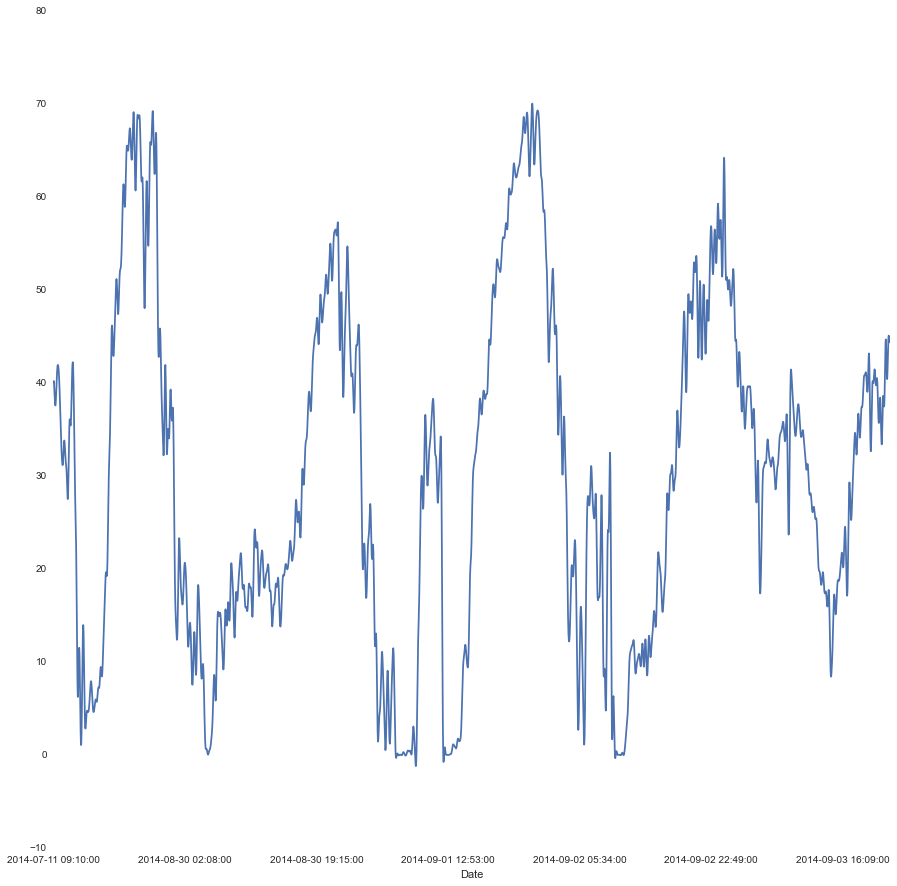

In [159]:
df_P['ref_o3_smooth'].plot(figsize = (15,15))

In [160]:
df_P.to_csv(path_or_buf = 'data/F8_raw_features.csv')